In [1]:
# Import
import sys, os
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, recall_score, precision_score

from statsmodels.tsa.seasonal import STL, seasonal_decompose

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.xgbod import XGBOD
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD

from adtk.visualization import plot
from adtk.detector import AutoregressionAD, QuantileAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, LevelShiftAD, VolatilityShiftAD, PcaAD, MinClusterDetector, SeasonalAD
from adtk.transformer import ClassicSeasonalDecomposition
from adtk.data import validate_series
from adtk.metrics import iou
from adtk.pipe import Pipeline

import joblib

2022-09-13 07:02:59.923428: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-13 07:02:59.925731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 07:02:59.925739: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Functions

In [2]:
def plot_outlier(predicted_df):
    fig, ax = plt.subplots(figsize=(12,4))
    outlier_points = predicted_df.loc[predicted_df['prediction'] == 1] #anomaly
    ax.plot(predicted_df.index, predicted_df['value'], color='blue', label = 'Normal')
    ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show()

In [3]:
def print_metrics(original_df, predicted_df):
    print("F1 Score:", f1_score(original_df['label'], predicted_df['prediction']))
    print("Recall:", recall_score(original_df['label'], predicted_df['prediction']))
    print("Precision:", precision_score(original_df['label'], predicted_df['prediction']))

In [4]:
def process_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    df = df.asfreq(freq='T')
    df = df.interpolate()
    df['label'] = df.label.astype(int)

    df['lag_1'] = df['value'].shift(1)
    df['lag_2'] = df['value'].shift(2)
    df['lag_3'] = df['value'].shift(3)
    df['lag_4'] = df['value'].shift(4)
    df.fillna(0, inplace=True)

    decompose = STL(df['value'], period=2).fit()
    df['resid'] = decompose.resid
    df['trend'] = decompose.trend
    df['seasonal'] = decompose.seasonal

    return df

## Load & Preprocess Data

In [5]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
input_df = pd.read_csv('data/0.csv')
df = process_data(input_df)

#### Feature Selection

In [6]:
# scaler = StandardScaler()
# np_scaled = scaler.fit_transform(df['value'].values.reshape(-1, 1))
# df['scaled'] = np_scaled
data = df[['value', 'resid', 'lag_1', 'lag_2', 'lag_3', 'seasonal']]

In [7]:
validate_df = validate_series(data)

In [8]:
outliers_fraction = float(0.06)

## LOF

In [9]:
lof_clf = LocalOutlierFactor()

In [10]:
lof_prediction_df = data.copy()
lof_prediction_df['anomaly'] = lof_clf.fit_predict(validate_df)
lof_prediction_df['prediction'] = np.where(lof_prediction_df['anomaly']==-1, 1, 0)
lof_prediction_df['prediction'].value_counts()

0    124466
1      7329
Name: prediction, dtype: int64

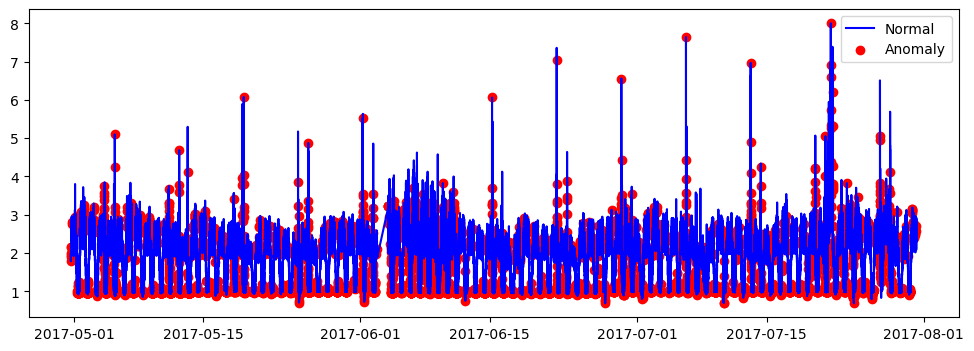

In [11]:
plot_outlier(lof_prediction_df)

In [13]:
print_metrics(df, lof_prediction_df)

F1 Score: 0.17615827418543564
Recall: 0.14918591442635365
Precision: 0.21503615772956747


## COPOD

In [14]:
copod_clf = COPOD(contamination=outliers_fraction)
copod_clf.fit(validate_df)

COPOD(contamination=0.06, n_jobs=1)

In [15]:
suod_prediction_df = data.copy()
suod_prediction_df['prediction'] = copod_clf.predict(data)
suod_prediction_df['prediction'].value_counts()

0    123887
1      7908
Name: prediction, dtype: int64

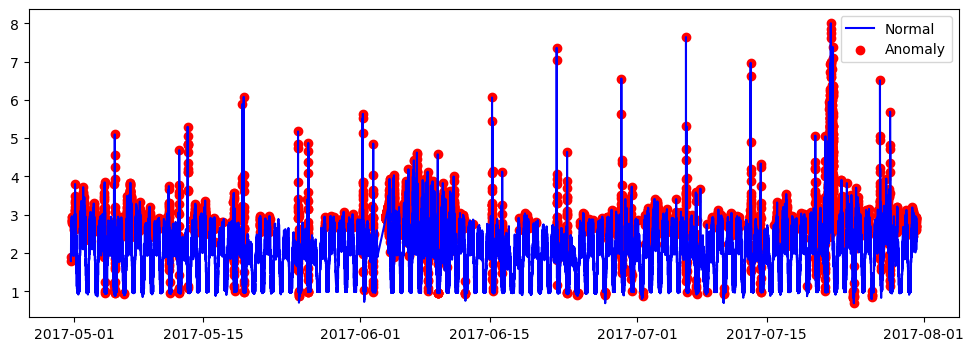

In [16]:
plot_outlier(suod_prediction_df)

In [17]:
print_metrics(df, suod_prediction_df)

F1 Score: 0.35773061931572114
Recall: 0.3127603180613404
Precision: 0.4178047546788063


## XGBOOST

In [18]:
# xgb_clf = joblib.load('xgb_detector.sav')

In [19]:
# xgb_clf = XGBOD(n_jobs=4)
# for i in np.array_split(validate_df, 6):
#     xgb_clf.fit(i.drop('label', axis=1), i['label'])

In [20]:
# xgb_prediction_df = data.copy()
# xgb_prediction_df['score'] = xgb_clf.decision_scores_ # outlier score
# ae_prediction_df['prediction'] = np.where(ae_prediction_df['score'] < 4.8, 0, 1)
# xgb_prediction_df['prediction'] = xgb_clf.predict(data.drop('label', axis=1))
# xgb_prediction_df['prediction'].value_counts()
# df['label'].value_counts()
# ae_prediction_df.groupby('prediction').mean()

In [21]:
# plot_outlier(xgb_prediction_df)

In [22]:
# print_metrics(df, xgb_prediction_df)

## IsolationForest

In [23]:
if_model =  IsolationForest(contamination=outliers_fraction)
if_model.fit(data)

IsolationForest(contamination=0.06)

In [24]:
if_prediction_df = df.copy()
if_prediction_df['anomaly'] = if_model.predict(data)
if_prediction_df['prediction'] = np.where(if_prediction_df['anomaly']==-1, 1, 0)
if_prediction_df['prediction'].value_counts()

0    123887
1      7908
Name: prediction, dtype: int64

#### Visualization

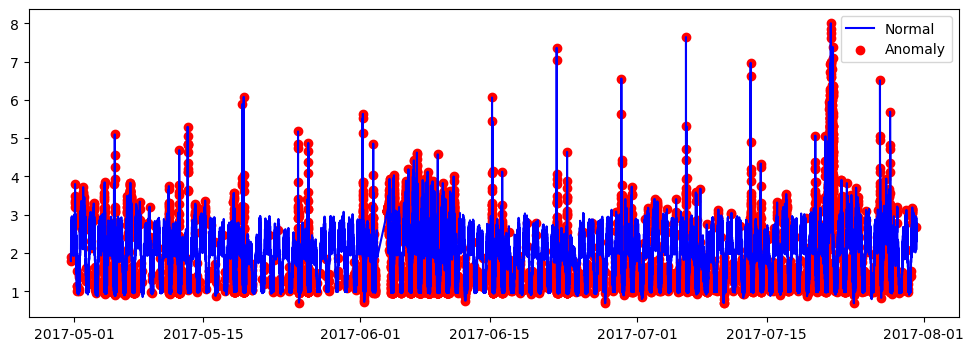

In [25]:
plot_outlier(if_prediction_df)

#### Metrics

In [26]:
print_metrics(df, if_prediction_df)

F1 Score: 0.5358380251190992
Recall: 0.46847784929950775
Precision: 0.6258219524532119


## KNN

In [27]:
knn_model =  KNN(contamination=outliers_fraction)
knn_model.fit(data)

KNN(algorithm='auto', contamination=0.06, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [28]:
knn_prediction_df = df.copy()
knn_prediction_df['anomaly'] = knn_model.predict(data)
knn_prediction_df['prediction'] = np.where(knn_prediction_df['anomaly']==1, 1, 0)
knn_prediction_df['prediction'].value_counts()

0    124443
1      7352
Name: prediction, dtype: int64

#### Visualization

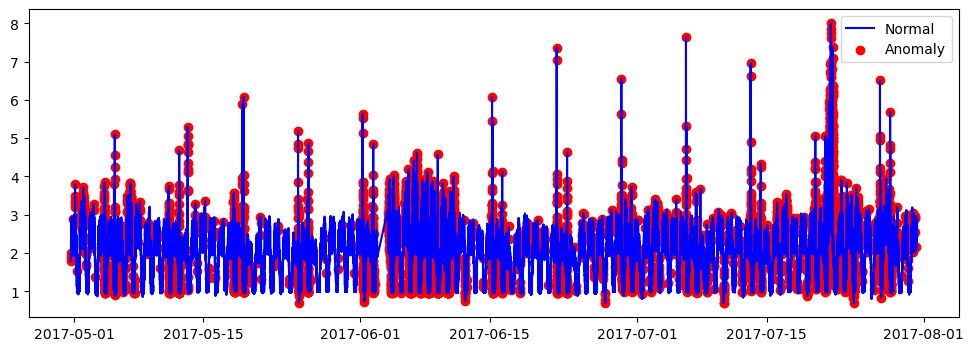

In [29]:
plot_outlier(knn_prediction_df)

#### Metrics

In [30]:
print_metrics(df, knn_prediction_df)

F1 Score: 0.5773610180843938
Recall: 0.4895872775463839
Precision: 0.7034820457018498


## AutoregressionAD

In [31]:
autoregression_ad = AutoregressionAD(n_steps=60, step_size=1, c=6.0)
anomalies = autoregression_ad.fit_detect(validate_df)

In [32]:
anomalies['prediction'] = np.where(anomalies['value']==True, 1, 0)

#### Visualization

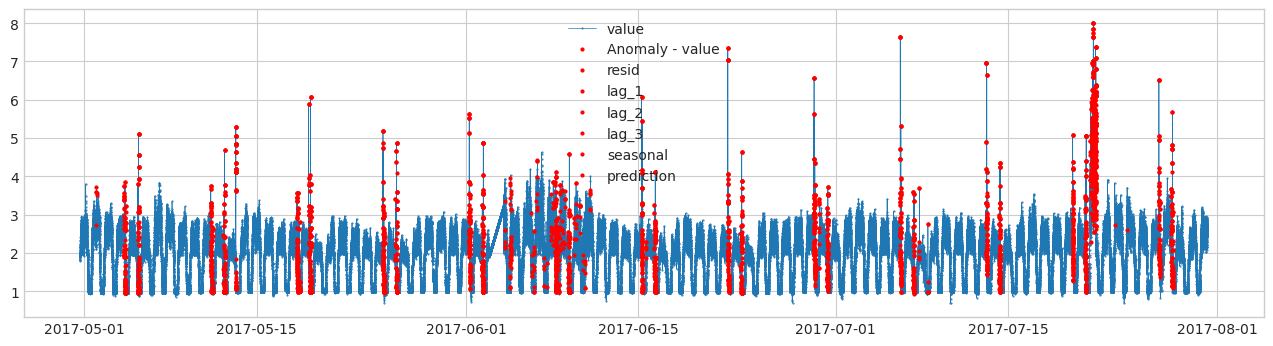

In [33]:
plot(validate_df['value'], anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2);

#### Metrics

In [34]:
print_metrics(df, anomalies)

F1 Score: 0.10788084801860631
Recall: 0.05708065126845892
Precision: 0.9804878048780488


## QuantileAD

In [35]:
quantile_ad = QuantileAD(high=0.999, low=0.001)
anomalies = quantile_ad.fit_detect(validate_df)

In [36]:
anomalies['prediction'] = np.where(anomalies['value']==True, 1, 0)

#### Visualization

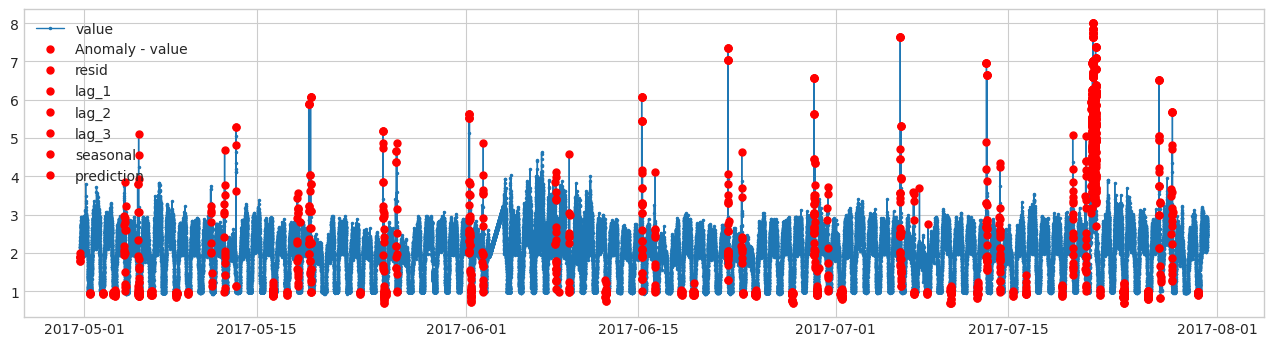

In [37]:
plot(validate_df['value'], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

#### Metrics

In [38]:
print_metrics(df, anomalies)

F1 Score: 0.02661491544219573
Recall: 0.013631200302915562
Precision: 0.5603112840466926


## InterQuartileRangeAD

In [39]:
iqr_ad = InterQuartileRangeAD(c=5)
anomalies = iqr_ad.fit_detect(validate_df)

In [40]:
anomalies['prediction'] = np.where(anomalies['value']==True, 1, 0)

#### Visualization

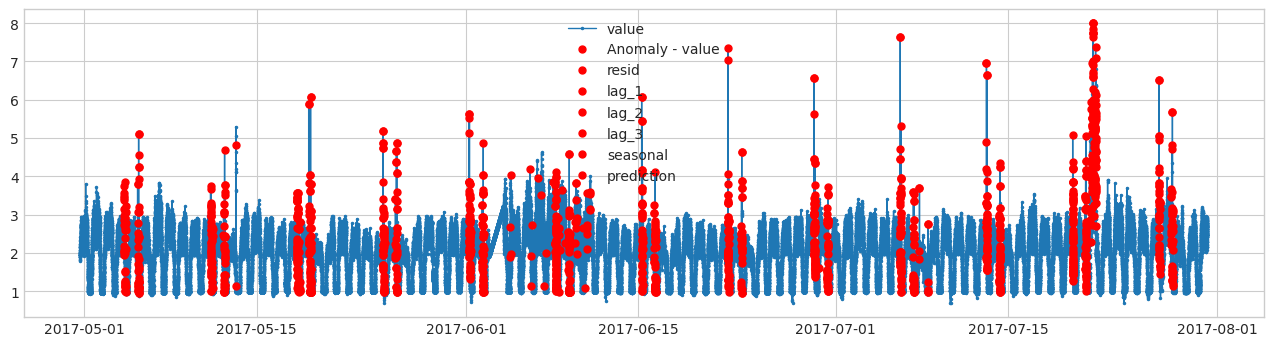

In [41]:
plot(validate_df['value'], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

#### Metrics

In [42]:
print_metrics(df, anomalies)

F1 Score: 0.0001893043066729768
Recall: 9.46611132146914e-05
Precision: 1.0


## GeneralizedESDTestAD

In [43]:
esd_ad = GeneralizedESDTestAD(alpha=0.5)
anomalies = esd_ad.fit_detect(validate_df)

In [44]:
anomalies['prediction'] = np.where(anomalies['value']==True, 1, 0)

#### Visualization

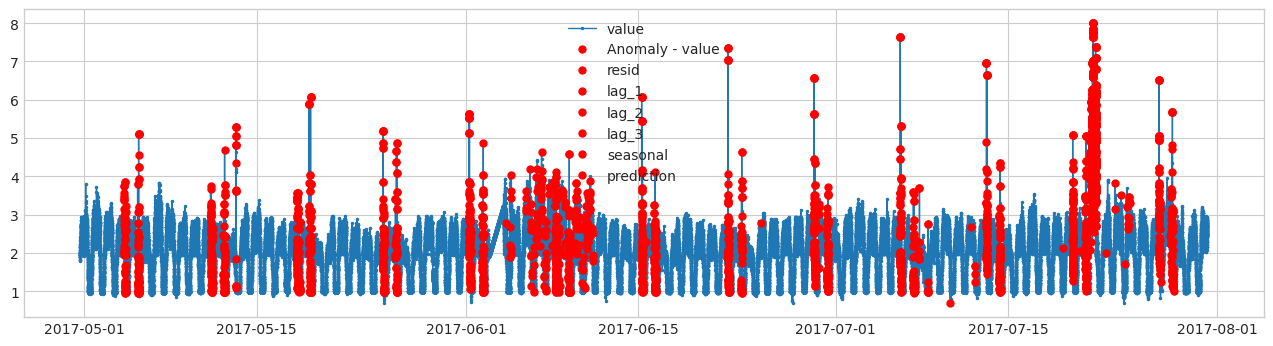

In [45]:
plot(validate_df['value'], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

#### Metrics

In [46]:
print_metrics(df, anomalies)

F1 Score: 0.034421806679691136
Recall: 0.01751230594471791
Precision: 1.0


## PersistAD

In [47]:
persist_ad = PersistAD(c=5.0, side='positive')
anomalies = persist_ad.fit_detect(validate_df)

In [48]:
anomalies['prediction'] = np.where(anomalies['value']==True, 1, 0)

#### Visualization

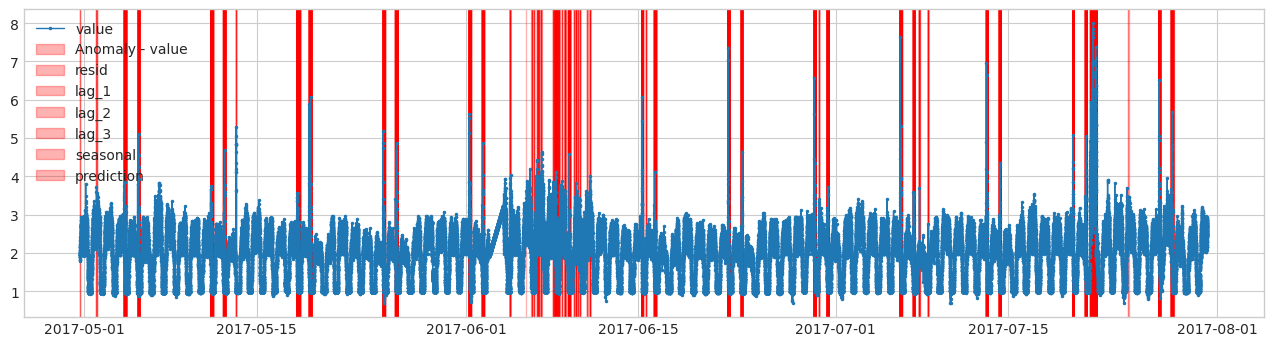

In [49]:
plot(validate_df['value'], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red');

#### Metrics

In [50]:
print_metrics(df, anomalies)

F1 Score: 0.0767901009917205
Recall: 0.03994698977659977
Precision: 0.9882903981264637


##### By default, PersistAD only check one previous value, which is good at capturing additive anomaly in short-term scale, but not in long-term scale because it is too near-sighted. In the following example, it fails to capture meaningful drops of price in a longer time scale.

In [51]:
persist_ad = PersistAD(c=2.5, side='both', window=20)
anomalies = persist_ad.fit_detect(validate_df)

In [52]:
anomalies['prediction'] = np.where(anomalies['value']==True, 1, 0)

#### Visualization

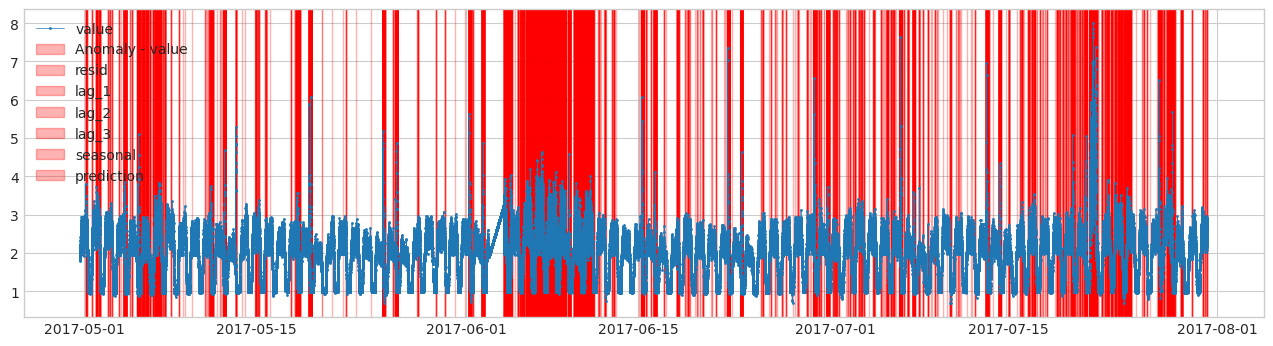

In [53]:
plot(validate_df['value'], anomaly=anomalies, anomaly_color='red');

#### Metrics

In [54]:
print_metrics(df, anomalies)

F1 Score: 0.325567413197054
Recall: 0.20503597122302158
Precision: 0.7899343544857768


## LevelShiftAD

In [55]:
level_shift_ad = LevelShiftAD(c=2.5, side='both', window=5)
anomalies = level_shift_ad.fit_detect(validate_df)

In [56]:
anomalies['prediction'] = np.where(anomalies.iloc[:, 0]==True, 1, 0)

#### Visualization

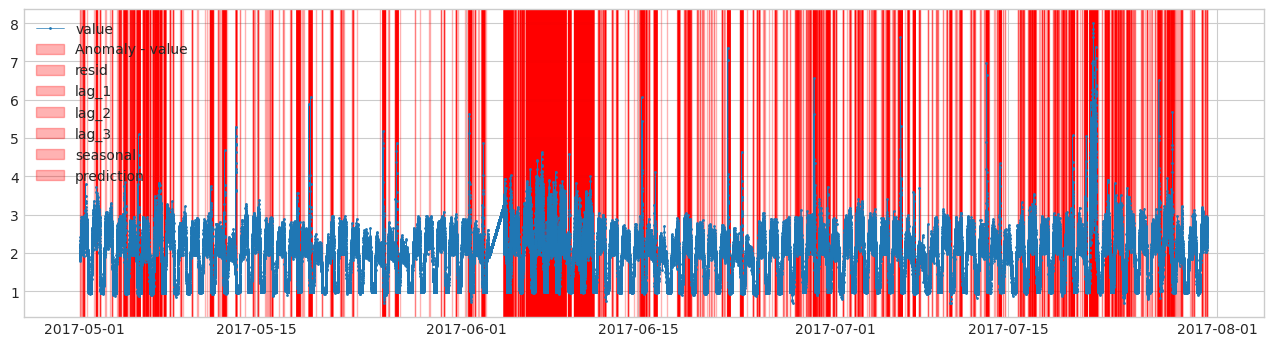

In [57]:
plot(validate_df['value'], anomaly=anomalies, anomaly_color='red');

#### Metrics

In [58]:
print_metrics(df, anomalies)

F1 Score: 0.3016138855054811
Recall: 0.18752366527830366
Precision: 0.7702177293934681


## VolatilityShiftAD

In [59]:
volatility_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(validate_df)

In [60]:
anomalies['prediction'] = np.where(anomalies.iloc[:, 0]==True, 1, 0)

#### Visualization

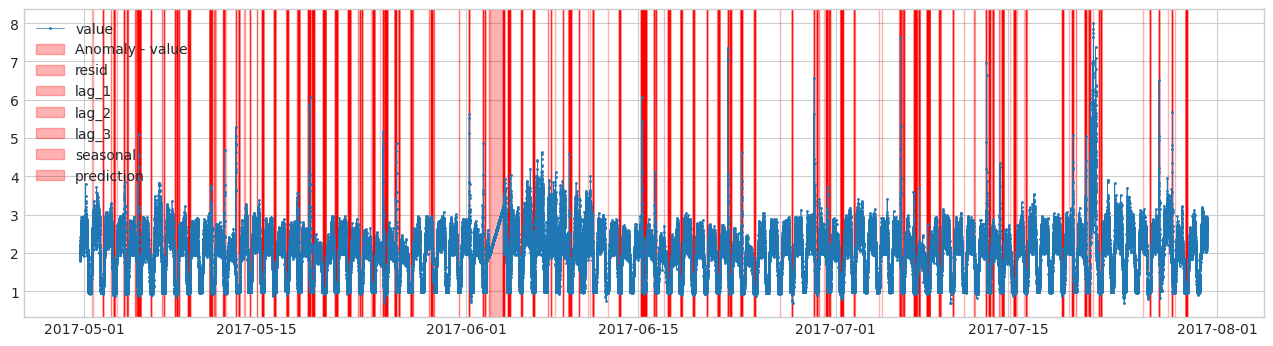

In [61]:
plot(validate_df['value'], anomaly=anomalies, anomaly_color='red');

#### Metrics

In [62]:
print_metrics(df, anomalies)

F1 Score: 0.0338824264189242
Recall: 0.020541461567588036
Precision: 0.09665924276169265


## MinClusterDetector

In [63]:
# This is more used in multivariate timeseries
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(data)

#### Visualization

[<AxesSubplot:>]

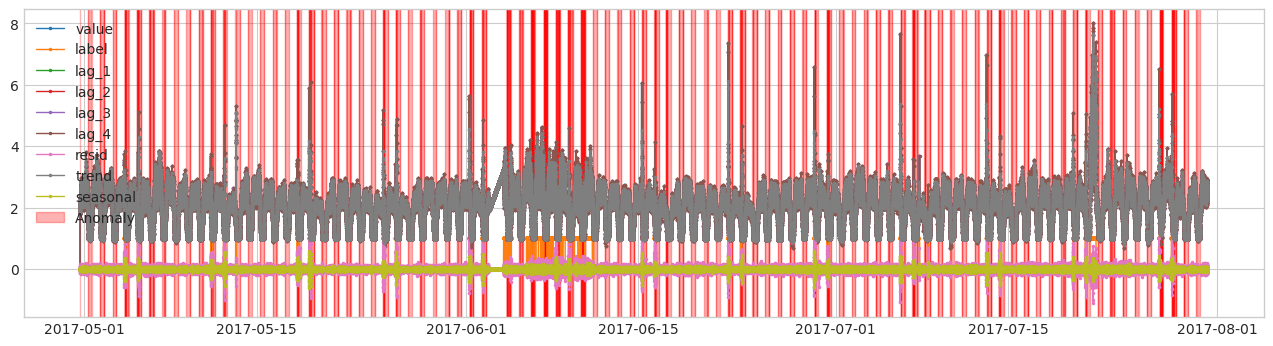

In [64]:
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

In [65]:
anomalies['prediction'] = np.where(anomalies==True, 1, 0)

#### Metrics

In [66]:
print_metrics(df, anomalies)

F1 Score: 0.13714101323007422
Recall: 0.32184778492995075
Precision: 0.08713480266529984


## PcaAD

In [67]:
pca_ad = PcaAD(k=2, c=2.5)
anomalies = pca_ad.fit_detect(data)

#### Visualization

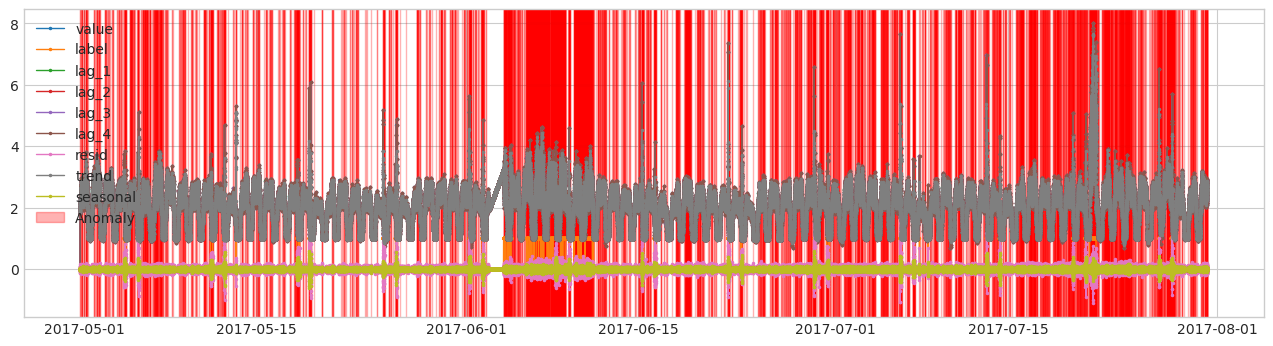

In [68]:
plot(validate_df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [69]:
anomalies['prediction'] = np.where(anomalies==True, 1, 0)

#### Metrics

In [70]:
print_metrics(df, anomalies)

F1 Score: 0.44766210725118755
Recall: 0.3702196137826581
Precision: 0.5660732378057606


## Pipeline

In [ ]:
from adtk.pipe import Pipeline
from adtk.transformer import ClassicSeasonalDecomposition
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.95, low=0.05))
]
pipeline = Pipeline(steps)

In [ ]:
# s = validate_series(s)
anomalies = pipeline.fit_detect(validate_df)
plot(validate_df['value'], anomaly=anomalies, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

In [ ]:
anomalies['prediction'] = np.where(anomalies==True, 1, 0)

#### Metrics

In [ ]:
print_metrics(df, anomalies)

## Kats

In [ ]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(validate_df, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

In [ ]:
ts_outlierDetection.outliers[0]

In [ ]:
air_passengers_ts_outliers_removed = ts_outlierDetection.remover(interpolate = False) # No interpolation
air_passengers_ts_outliers_interpolated = ts_outlierDetection.remover(interpolate = True) # With interpolation

In [ ]:
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2)
air_passengers_ts_outliers_removed.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[0])
ax[0].set_title("Outliers Removed : No interpolation")
air_passengers_ts_outliers_interpolated.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[1])
ax[1].set_title("Outliers Removed : With interpolation")
plt.show()

## pyfbad Anomaly detection

In [ ]:
# import plotly.express as px
# from plotly.offline import iplot
# from pyfbad.data import database as db
# from pyfbad.models import models as md
# from pyfbad.features import create_feature as cf
# from pyfbad.notification import notifications as ntf